# Spike shape

author: laquitainesteeve@gmail.com

Purpose: describe ground truth action potential shapes with WaveMap clustering for biophysical evoked neuropixel demo.

Execution time:

Special hardware: on CPU, does not require GPU.

## Setup

Create, activate and select virtual environment kernel `demo` from (envs/demo.yml):

```bash
python -m ipykernel install --user --name demo --display-name "demo" # create kernel
```

In [130]:
%%time
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import packages
import os
import shutil
import numpy as np
from dandi.dandiapi import DandiAPIClient
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
from spikeinterface import extract_waveforms
import spikeinterface as si
from matplotlib import pyplot as plt;
import multiprocessing
import torch
import pandas as pd
import seaborn as sns
import matplotlib
import sys
from scipy.stats import kruskal
import scikit_posthocs as sp
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp # set context "fork" for macOS or "spawn"
import sklearn
import random 
from umap import umap_ as umap
import networkx as nx
import community as community_louvain
from collections import Counter

print("spikeinterface version:", si.__version__)

# dandiset parameters
dandiset_id = '001250'
filepath_evoked = 'sub-demo-npx-bio-evoked/sub-demo-npx-bio-evoked_ecephys.nwb'

# project path
proj_path = "/Users/steeve_laquitaine/Desktop/EPFL/2022_2024_bbp/spikebias/"
#proj_path = "/home/jovyan/steevelaquitaine/spikebias/"
os.chdir(proj_path)

# enable spike bias import
sys.path.insert(0, proj_path)

from src.nodes.utils import get_config, demean
from src.nodes.validation import snr
from src.nodes.validation import amplitude, power_demo, power

# evoked demo
cfg_e, param_cfg_e = get_config("silico_neuropixels", "npx_evoked").values() # config
FREQ_MIN_E = param_cfg_e["run"]["preprocessing"]["min_filter_freq"] # preprocessing parameters
FREQ_MAX_E = param_cfg_e["run"]["preprocessing"]["max_filter_freq"]

# waveform parameters
study_path_e = os.path.join(proj_path + "dataset/03_demo/study_npx_evoked/")
job_kwargs = dict(n_jobs=-1, chunk_duration="1s", progress_bar=True)    
MS_BEFORE = 6.0   # ms, window before spike (large to find alignment)
MS_AFTER = 6.0    # ms, window after spike

# layer parameter
lyrs = ["L5"]
prm = dict()
prm["SFREQ_NS"] = 40000  # sampling frequency
prm["SFREQ_NE"] = 20000

# plot parameters
FIG_SIZE = (1.5, 1.5)
cl = dict()
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_MEDIAN"] = (1, 0.76, 0)

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

FIG_SIZE = (1, 1)
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 1.5,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.06,
}
pm_fit1 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}
pm_fit2 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
spikeinterface version: 0.101.2
2025-04-07 15:38:36,140 - root - utils.py - get_config - INFO - Reading experiment config.
2025-04-07 15:38:36,232 - root - utils.py - get_config - INFO - Reading experiment config. - done
CPU times: user 75.4 ms, sys: 4.15 ms, total: 79.5 ms
Wall time: 95.4 ms


## Load demo

In [3]:
%%time

with DandiAPIClient() as client: # download the extractors from Dandi archive
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath_evoked)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)
RecordingE = se.NwbRecordingExtractor(file_path=s3_path, stream_mode="remfile") # get extractor
#RecordingE = spre.astype(RecordingE, "int16") # compress to int16 (like kilosorts)
RecordingE = spre.bandpass_filter(RecordingE, freq_min=FREQ_MIN_E, freq_max=FREQ_MAX_E)  # band-pass filter
RecordingE = spre.common_reference(RecordingE, reference="global", operator="median") # common reference
traces_ne = RecordingE.get_traces() # get trace array
SortingE = se.NwbSortingExtractor(file_path=s3_path, stream_mode="remfile") # get SortingExtractor

# report
print(RecordingE)
print(SortingE)

NwbSortingExtractor: 1836 units - 1 segments - 20.0kHz
  file_path: https://dandiarchive.s3.amazonaws.com/blobs/11c/8bf/11c8bffc-d1a4-4ed4-8dfa-dce26d30e31e
CPU times: user 30.6 s, sys: 11 s, total: 41.6 s
Wall time: 7min 47s


## Compute

### Waveforms data

In [5]:
%%time 

## extract waveforms
- delete existing waveform data
- create WaveformExtractors 
if os.path.exists(study_path_e): 
    os.chmod(study_path_e, 0o777) # write permission
    shutil.rmtree(study_path_e) # delete existing data

WaveformExtractor = extract_waveforms(
    RecordingE,
    SortingE,
    study_path_e,
    sparse=True, # more efficient on 8 cores, 8 GB RAM machine
    ms_before=MS_BEFORE,
    ms_after=MS_AFTER,
    max_spikes_per_unit=500,
    unit_batch_size=None,
    overwrite=None,
    seed=0,
    **job_kwargs
)

## ...or load pre-extracted ones
# WaveformExtractor = si.load_waveforms(study_path_e) # load the WaveformExtractor

CPU times: user 70.3 ms, sys: 6.31 s, total: 6.38 s
Wall time: 15.3 s


In [ ]:
%%time

# CUSTOM FUNCTION FOR PARALLEL COMPUTING
# Get each unit's six largest spike templates on six sites
# and re-order in descending order

nsamples = WaveformExtractor.nsamples # number of waveform samples
sites_ix = np.arange(0, RecordingE.get_num_channels(),1) # site indices

# report
print("# of samples of a waveform:", nsamples)
print("sites:", sites_ix)

# unit-test
assert (MS_BEFORE + MS_AFTER) * RecordingE.get_sampling_frequency()/ 1000 == nsamples, "nsamples should match"

def get_unit_largest_templates_parallelized(dummy, cell_id: int):
    """Get each unit's six largest spike templates on six sites
    and re-order in descending order.
    
    Align unit spikes by first extracting -6:+6 ms before 
    and after the spike timestamp then centering unit templates on 
    their trough (maximal negative peak), teducing the template 
    period to -3:+3 ms before applying wavemap

    """

    N_SPIKES = 6 # six largest spikes on six sites
    MSAMP_BASELINE = 20 # window to evaluate background noise ref. for normalization
    wfs = WaveformExtractor.get_waveforms(cell_id) # waveforms (n_spikes, n_samples, n_sites)
    nsamples = wfs.shape[1] # # of waveform samples
    N_SITES = wfs.shape[2] # number of sites
    SFREQ = WaveformExtractor.sampling_frequency # sampling frequency

    # shorten period to -3 and +3ms to avoid
    # collisions from other spikes
    MS_AROUND_DENOISE = 3
    nsamples_denoise = int(MS_AROUND_DENOISE * SFREQ / 1000) # e.g., 60 timepoints
    timestamp_sample = int(nsamples/2)

    # shorted-period waveforms (n_spikes, nsamples/2, n_sites)
    wfs_short = wfs[:,timestamp_sample - nsamples_denoise: timestamp_sample + nsamples_denoise, :]

    # get this unit's templates per site
    site_templates = []
    peak1_amps = []
    trough_amps = []
    peak2_amps = []

    # get template features per sites
    #for _, site in enumerate(SITES_IN_CTX_IX):
    for site in range(N_SITES):

        # calculate template ((nsamples,))
        template_short = np.median(wfs_short[:, :, site].T, axis=1)
        template = np.median(wfs[:, :, site].T, axis=1)

        # subtract baseline: e.g.,voltage of 20 first timepoints 
        # ((nsamples,))
        template_short -= np.median(template_short[:MSAMP_BASELINE])
        template -= np.median(template[:MSAMP_BASELINE])

        # find peak 1 (trough), and peak 2 (amplidude) voltages
        # - if trough is at time 0, there is too much noise
        # thus set the site data to 0 -> will not be picked
        # up for max trough, or peak
        ix_trough = np.argmin(template_short)
        if ix_trough == 0:
            peak1_amps.append(0)
            trough_amps.append(0)
            peak2_amps.append(0)
        else:
            peak1_amps.append(template_short[np.argmax(template_short[:ix_trough])])
            trough_amps.append(template_short[ix_trough])
            peak2_amps.append(template_short[np.argmax(template_short[ix_trough:])])

        # recording full template for each site 
        # list of (nsamples,) templates with length N_SITES
        site_templates.append(template)

    # (nsamples, n_sites) e.g., 240 x 30 (for sparse waveformextractor)
    site_templates = np.array(site_templates).T

    # get amplitudes from peak1 (row 1), trough (row 2)or peak2 (row3),
    # depending on which is largest across sites
    peaks_and_trough = np.vstack(
        [np.array(peak1_amps), np.array(trough_amps), np.array(peak2_amps)]
    )
    peak1_trough_or_peak2 = np.argmax(np.nanmax(np.abs(peaks_and_trough), axis=1))

    # if peak, reorder sites based on peak, else on trough
    descend_sort_ix = np.argsort(peaks_and_trough[peak1_trough_or_peak2, :])[::-1]

    # case trough
    if peak1_trough_or_peak2 == 1:
        descend_sort_ix = np.argsort(peaks_and_trough[peak1_trough_or_peak2, :])

    # order associated sites (n_sites,)
    ordered_sites = np.arange(0, N_SITES, 1)[descend_sort_ix]

    # make a vector
    # (nsamples, n_spikes) e.g., (240, 6 largest spike descending)
    unit_i_spike = site_templates[:, descend_sort_ix[:N_SPIKES]]
    unit_i_spike =  unit_i_spike.T.flatten() # (240 * 6,)
    assert unit_i_spike.shape[0]==nsamples*N_SPIKES, "unit_i_spike should be nsamples*n_spikes"
    return {"templates": unit_i_spike, "sites": ordered_sites}

# of samples of a waveform: 240
sites: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
CPU times: user 1.26 ms, sys: 1.26 ms, total: 2.52 ms
Wall time: 2.86 ms
Compiler : 1.08 s


In [26]:
%%time 

# parameters
MIN_N_SPIKES = 100 # minimum number of spikes to be considered

# get all units
single_units = WaveformExtractor.unit_ids

# select the most active units (ensuring they have sufficient spikes to 
# produce a reasonable average template)
n_spikes = [len(SortingE.get_unit_spike_train(unit)) for ui, unit in enumerate(single_units)] # num spikes
sorted_ix = np.argsort(n_spikes)[::-1] # sort by num spikes ascending
n_spikes = np.array(n_spikes)[sorted_ix]
sorted_single_units = single_units[sorted_ix]
selected_units = sorted_single_units[n_spikes > MIN_N_SPIKES] # select most active
print("# of selected units:", len(selected_units))

# of selected units: 246
CPU times: user 4.1 ms, sys: 337 μs, total: 4.44 ms
Wall time: 4.14 ms


In [138]:
%%time 

# takes 3 min for the 227 single units (KSLabel)
# takes 8 mins for all (1310) units
# compute unit's six largest templates
# (parallelized over units)
with ProcessPoolExecutor(mp_context=mp.get_context('fork')) as executor:
    site_templates = executor.map(
        get_unit_largest_templates_parallelized,
        np.arange(0, len(single_units), 1),  # dummy, not used
        selected_units,
    )

# collect
site_templates = list(site_templates)

# format for wavemap (templates x (6 sites x ntimepoints))
site_templates_all = []
sites = []
for ix in range(len(selected_units)):
    site_templates_all.append(site_templates[ix]["templates"].tolist())
    sites.append(site_templates[ix]["sites"].tolist())
templates_for_wavemap = np.array(site_templates_all)

# keep non-nan (existing) spike templates
#has_spike_unit_ix = np.where(np.isnan(templates_for_wavemap).sum(axis=1)==0)[0]
#templates_for_wavemap = templates_for_wavemap[has_spike_unit_ix, :]
#single_units_has_spike = selected_units[has_spike_unit_ix]

CPU times: user 336 ms, sys: 238 ms, total: 574 ms
Wall time: 7.15 s


### Cluster with six-site WaveMap

In [139]:
# parameters
ALIGNED_AROUND = 60 # 3 ms before and after the spike timestamp

# number of sites
n_sites_for_umap = int(templates_for_wavemap.shape[1] / nsamples)
print("# sites to use for UMAP:", n_sites_for_umap)

# isolate each unit's largest template (because 
# we order all spike templates for each unit (row) 
# in descending order (it is the first template, i.e., 
# first nsamples timepoints).
largest_templates = templates_for_wavemap[:, :nsamples]
print("largest template shape:", largest_templates.shape)

# loop over units
aligned_temps = [] # aligned templates

units = []
ix_troughs = []

# loop over units
for ix in range(len(selected_units)):

    # find spike trough
    ix_trough = np.argmin(largest_templates[ix, :])
    ix_troughs.append(ix_trough)

    # align the templates for each site
    # to the location of the first positive peak of
    # the largest template
    templates_unit_i = []
    for jx in range(n_sites_for_umap):
        
        # only when period before the spike timestamp is
        # positive
        if jx * nsamples + ix_trough - ALIGNED_MAX_BEFORE > 0:
            if jx * nsamples + ix_trough + ALIGNED_MAX_AFTER < templates_for_wavemap.shape[1]:

                # align templates to peak
                try:
                    aligned_tp = templates_for_wavemap[
                            ix,
                            jx * nsamples
                            + ix_trough
                            - ALIGNED_AROUND : jx * nsamples
                            + ix_trough
                            + ALIGNED_AROUND,
                        ]
                    templates_unit_i.append(aligned_tp)
                    # check that the aligned template is of the right size
                    assert aligned_tp.shape[0] == 2*ALIGNED_AROUND
                except:
                    print("reduce the length of the preceding and following periods")
                
    try:
        # re-concatenate into a single row vector
        templates_unit_i2 = np.array(templates_unit_i).flatten()
        
        # we keep units for which no spike waveform samples were lost
        # during the alignment
        if templates_unit_i2.shape[0]== 2*ALIGNED_AROUND * n_sites_for_umap:
            aligned_temps.append(templates_unit_i2)
        
            # record units kept
            units.append(ix)
    except:
        pass
    # concatenate all the templates that could be aligned
    # with without loss of data
    #if templates_unit_i2.shape[0]==n_sites_for_umap * 2 * ALIGNED_AROUND:
    #    aligned_temps.append(templates_unit_i2)
aligned_temps = np.array(aligned_temps)
units_kept = selected_units[np.unique(units)]

# sites to use for UMAP: 6
largest template shape: (246, 240)
reduce the length of the preceding and following periods
reduce the length of the preceding and following periods
reduce the length of the preceding and following periods
reduce the length of the preceding and following periods
reduce the length of the preceding and following periods


## Plot

Text(0.5, 1.0, '6 largest aligned templates in decreasing order')

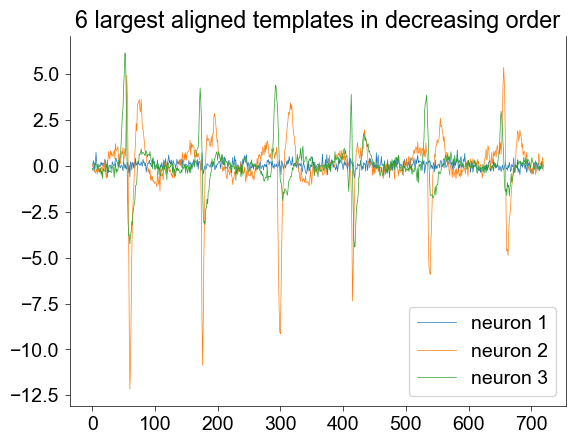

In [140]:
# plot three neurons' largest templates (average spikes over site) for six sites.
plt.plot(aligned_temps[:3,: ].T);
plt.legend(["neuron 1", "neuron 2", "neuron 3"])
plt.title("6 largest aligned templates in decreasing order")

In [141]:
%%time 

# APPLY UMAP CLUSTERING 

# takes 13 secs
SPIKE_PERIOD = int(
    aligned_temps.shape[1] / n_sites_for_umap
)  # in timepoints (6 ms at 40KHz)
RAND_STATE = 42  # 42

# normalize waveform amplitudes between 0 and 1.
normWFs = sklearn.preprocessing.normalize(aligned_temps, norm="max")

# reduce waveform dimensionality with UMAP
# umap reduces to two dimensions by default
np.random.seed(RAND_STATE)
os.environ["PYTHONHASHSEED"] = str(RAND_STATE)
random.seed(RAND_STATE)
reducer = umap.UMAP()
mapper = reducer.fit(normWFs)

# clustering with Louvain
G = nx.from_scipy_sparse_array(mapper.graph_)
clustering = community_louvain.best_partition(G)
clustering_solution = list(clustering.values())

# create 2D embedding
embedding = reducer.fit_transform(normWFs)

# get cluster profiles
umap_df = pd.DataFrame(embedding, columns=("x", "y"))
umap_df["waveform"] = list(normWFs)
umap_df["cluster_id"] = clustering_solution

# get cluster profiles
profiles = np.unique(umap_df["cluster_id"])

## Plot embeddings

profile (count): 6
profiles: [0 1 2 3 4 5]


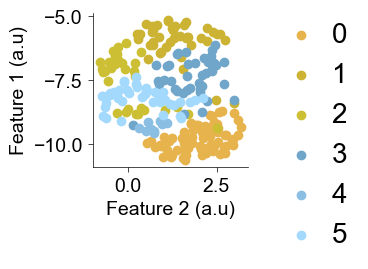

In [ ]:
%%time 

# set color of cluster profiles
colors = np.array(
    [
        [0.9, 0.7, 0.3],  # yellow/gold
        [0.8, 0.70, 0.2],  # lighter yellow/green
        [0.8, 0.75, 0.2],  # lightest yellow/green
        # [1, 0, 0],  # red
        # [0.33, 0.29, 0.58],  # purple blue
        [0.44, 0.65, 0.79],  # light blue
        [0.54, 0.75, 0.89],  # lighter blue
        [0.64, 0.85, 0.99],  # lightest blue
        # [254 / 255, 235 / 255, 226 / 255],  # purple variation
        # [252 / 255, 197 / 255, 192 / 255],  # purple variation
        [250 / 255, 159 / 255, 181 / 255],  # purple variation
        [247 / 255, 104 / 255, 161 / 255],  # purple variation
        [221 / 255, 52 / 255, 151 / 255],  # purple variation
        [174 / 255, 1 / 255, 126 / 255],  # purple variation
    ]
)

# plot embedding
f, ax = plt.subplots(1, figsize=(2,2))
for ix, profile_i in enumerate(profiles):
    ax.scatter(
        umap_df["x"][umap_df["cluster_id"] == profile_i].tolist(),
        umap_df["y"][umap_df["cluster_id"] == profile_i].tolist(),
        marker="o",
        color=colors[ix],
        label=profile_i,
    )

# legend
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Feature 1 (a.u)")
ax.set_xlabel("Feature 2 (a.u)")
plt.legend(fontsize=20, bbox_to_anchor=(1, 1.1), **legend_cfg)

# report cluster profile identifiers
print("profile (count):", len(np.unique(umap_df["cluster_id"])))
print("profiles:", profiles)

## Plot spike shape clusters

as fig3 Paulk Nat Neurosci 2022

- first site (column) is the site with the largest peak to peak amplitude
- Second site (column) is the site with the second largest peak to peak amplitude

2025-04-07 15:38:41,777 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 15:38:41,888 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 15:38:41,971 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 15:38:42,039 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 15:38

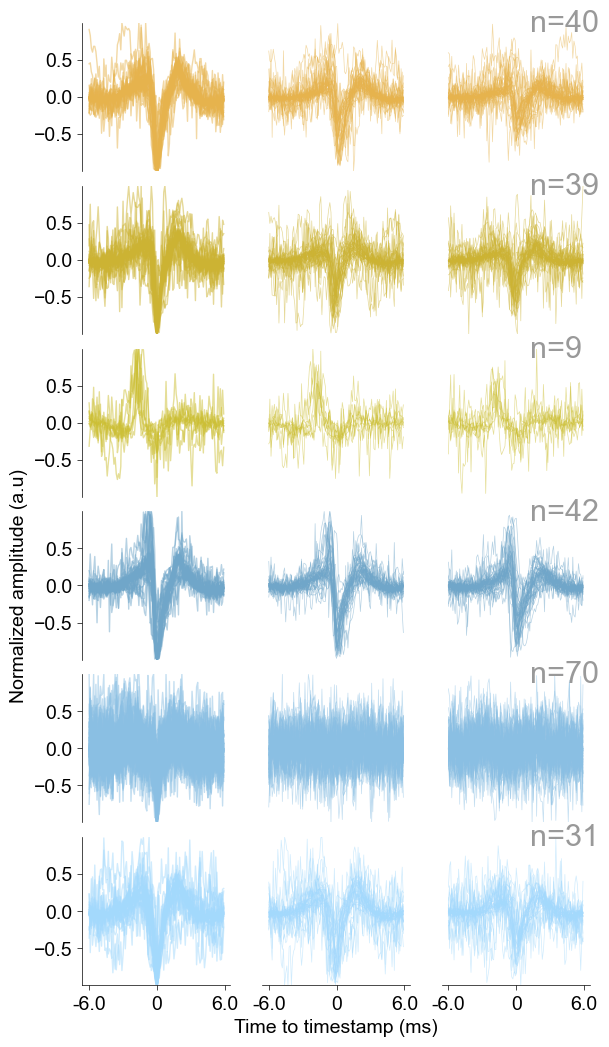

In [131]:
# takes 2 secs
counts = Counter(umap_df["cluster_id"])

# order cluster profile panels
profiles = [3, 5, 4, 1, 0, 2]

# spike timestamp locatoon
timestamp_timepoint = SPIKE_PERIOD / 2

# setup figure
fig, axes = plt.subplots(len(profiles), 3, figsize=(5 * 1.5, 7 * 1.5))

YLIM = [-1, 1]

for ix, profile_i in enumerate(profiles):

    # site 1
    # unit templates
    axes[ix, 0].plot(
        normWFs[umap_df["cluster_id"] == profile_i, :SPIKE_PERIOD].T,
        color=colors[ix],
        alpha=0.5,
        linewidth=1,
    )
    axes[ix, 0].set_box_aspect(1)  # square axis
    axes[ix, 0].spines[["top", "right"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 0].spines[["bottom"]].set_visible(False)
    axes[ix, 0].legend(frameon=False)
    axes[ix, 0].set_yticks([-0.5, 0, 0.5])
    axes[ix, 0].set_ylim(YLIM)

    if ix == 3:
        axes[ix, 0].set_ylabel("Normalized amplitude (a.u)")
    axes[ix, 0].set_xticks([])
    axes[ix, 0].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 0].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 0].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])

    # site 2
    axes[ix, 1].plot(
        normWFs[umap_df["cluster_id"] == profile_i, SPIKE_PERIOD : 2 * SPIKE_PERIOD].T,
        color=colors[ix],
        alpha=0.5,
        linewidth=0.5,
    )
    axes[ix, 1].set_box_aspect(1)  # square axis$
    axes[ix, 1].spines[["top", "right"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 0].spines[["bottom"]].set_visible(False)

    axes[ix, 1].set_yticks([-0.5, 0, 0.5])
    axes[ix, 1].set_ylim(YLIM)

    axes[ix, 1].spines[["left", "right", "top"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 1].spines[["bottom"]].set_visible(False)
    axes[ix, 1].set_yticklabels([])
    axes[ix, 1].set_yticks([])
    axes[ix, 1].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
    axes[ix, 1].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 1].set_xticks([])
    axes[ix, 1].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 1].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 1].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
        axes[ix, 1].set_xlabel("Time to timestamp (ms)")

    # site 3
    axes[ix, 2].plot(
        normWFs[
            umap_df["cluster_id"] == profile_i, 2 * SPIKE_PERIOD : 3 * SPIKE_PERIOD
        ].T,
        color=colors[ix],
        alpha=0.5,
        linewidth=0.5,
    )
    axes[ix, 2].set_box_aspect(1)  # square axis

    axes[ix, 2].set_yticks([-0.5, 0, 0.5])
    axes[ix, 2].set_ylim(YLIM)

    axes[ix, 2].spines[["left", "right", "top"]].set_visible(False)
    if not ix == len(profiles) - 1:
        axes[ix, 2].spines[["bottom"]].set_visible(False)
    axes[ix, 2].set_yticklabels([])
    axes[ix, 2].set_yticks([])
    axes[ix, 2].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
    axes[ix, 2].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 2].set_xticks([])
    axes[ix, 2].set_xticklabels([])
    if ix == len(profiles) - 1:
        axes[ix, 2].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
        axes[ix, 2].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
    axes[ix, 2].annotate(
        "n=" + str(counts[profile_i]),
        xy=(0.6, 0.9),
        xycoords="axes fraction",
        horizontalalignment="left",
        verticalalignment="bottom",
        color=(0.6, 0.6, 0.6),
        fontsize=22,
    )

fig.tight_layout(**tight_layout_cfg)
fig.subplots_adjust(wspace=-0.45, hspace=0.1)